In [ ]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from models import (
    UNetDiffusion,
    UNet_diffusion_normal,
    UNet_diffusion_sample,
    UNet_diffusion_mixednormal,
    UNet_diffusion_mvnormal,
)
import torch
from models import (
    Diffusion,
    generate_diffusion_samples_low_dimensional,
    DistributionalDiffusion,
)
import matplotlib.pyplot as plt
import numpy as np
from data import PDE1D

from cmap import Colormap
colormap = Colormap("seaborn:icefire").to_mpl()

device = "cuda"

In [ ]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="KS",
    var="test",
    downscaling_factor=1,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="zero",
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [ ]:
cfg_scale = 0
x_T_sampling_method = "standard"
n_timesteps = 50
n_samples = 5
t_steps = 50

In [ ]:
def plot_predictions(input, target, pred, grid, last_t_timesteps=2):
    fig, axs = plt.subplots(3, 3, figsize=(18, 8))

    input_last_t = input[:, last_t_timesteps - 1].cpu()
    mean_prediction = pred[:, 0].mean(axis=-1).cpu()
    pred = pred.cpu()
    target = target.cpu()
    for i in range(3):
        axs[i, 0].plot(grid, input_last_t[i].numpy())

        for j in range(n_samples):
            axs[i, 1].plot(
                grid,
                (pred[i, 0, :, j] + input_last_t[i]).numpy(),
                alpha=0.2,
                color="grey",
            )
        axs[i, 1].plot(grid, (target[i, 0] + input_last_t[i]).numpy())
        axs[i, 1].plot(
            grid,
            (mean_prediction[i] + input_last_t[i]).numpy(),
            label="Mean prediction",
            linestyle="dashed",
        )
        axs[i, 1].set_ylim(
            [
                (mean_prediction[i] + input_last_t[i]).min() - 0.2,
                (mean_prediction[i] + input_last_t[i]).max() + 0.2,
            ]
        )

        for j in range(n_samples):
            axs[i, 2].plot(grid, pred[i, 0, :, j].numpy(), alpha=0.2, color="grey")
        axs[i, 2].plot(grid, target[i, 0].numpy(), label="Truth")
        axs[i, 2].plot(
            grid,
            mean_prediction[i].numpy(),
            label="Mean prediction",
            linestyle="dashed",
        )
        # axs[i,2].set_ylim([mean_prediction[i].min()-0.2, mean_prediction[i].max()+0.2])

        axs[i, 2].legend()

    axs[0, 2].set_title("Residual prediction")
    axs[0, 1].set_title("Original scale prediction")
    axs[0, 0].set_title("Input")

In [5]:
# Batch to analyze
b = 0

In [ ]:
n_test = len(test_dataset)
indices = np.random.choice(n_test, 3, replace=False)
indices = np.array([357, 211, 833])
input = []
target = []
trajectory = []
for idx in indices:
    target_tensor, input_tensor = test_dataset.get_trajectory(idx, length=n_timesteps)
    target_tensor = target_tensor.unsqueeze(0).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input.append(input_tensor)
    target.append(target_tensor[:, :, 2] - input_tensor[:, -2])
    trajectory.append(target_tensor)
input = torch.cat(input, dim=0)
target = torch.cat(target, dim=0)
trajectory = torch.cat(trajectory, dim=0)

In [31]:
def sample_low_dimensional(
    diffusion,
    distributional_method,
    model,
    n,
    conditioning=None,
    cfg_scale=3,
    pred=None,
    gt_images=None,
):
    
    torch.manual_seed(0)
    
    model.eval()
    predictions = []
    if distributional_method == "deterministic":
         with torch.no_grad():
            # Make sure x starts on the correct device
            x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True).to(device)

            # Move conditioning and pred if provided
            if conditioning is not None:
                conditioning = conditioning.to(device)
            if pred is not None:
                pred = pred.to(device)

            for i in reversed(range(1, diffusion.noise_steps)):
                t = torch.full((n,), i, dtype=torch.long, device=device)

                # Predict noise
                predicted_noise = model(x, t, conditioning, pred=pred)
                predictions.append(predicted_noise)

                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None, pred=pred)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)

                # Sample next step
                x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)
    else:
        with torch.no_grad():
            x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
            for i in reversed(range(1, diffusion.noise_steps)):
                t = (torch.ones(n) * i).long().to(diffusion.device)
                predicted_noise_distribution_params = model(
                    x, t, conditioning, pred=pred
                )
                predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
                predictions.append(predicted_noise_distribution_params)
                if cfg_scale > 0:
                    uncond_predicted_noise = diffusion.sample_noise(model, x, t, None, pred)
                    predicted_noise = torch.lerp(
                        uncond_predicted_noise, predicted_noise, cfg_scale
                    )
                x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)
    model.train()
    return torch.stack(predictions, dim=-1)

# Deterministic

In [37]:
ckpt_path = "../results/KS/deterministic/Datetime_20250902_080935_Loss_1D_KS_UNet_diffusion_deterministic_T50_DDIM1.pt"
distributional_method = "deterministic"
beta_endpoints = (0.001, 0.35)

In [38]:
model = UNetDiffusion(
    d=1,
    conditioning_dim=3,
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    init_features=64,
    domain_dim=target_dim,
)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)

/tmp/ipykernel_664028/2769439003.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


In [39]:
diffusion = Diffusion(
    noise_steps=n_timesteps,
    img_size=target.shape[1:],
    device=input.device,
    x_T_sampling_method=x_T_sampling_method,
    ddim_churn=1.0,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints,
    tau=1,
)

In [40]:
predictions_deterministic = sample_low_dimensional(
    diffusion, distributional_method, model, input.shape[0], conditioning=input, pred=None, cfg_scale=cfg_scale
)

# Normal

In [41]:
ckpt_path = "../results/KS/normal/Datetime_20250831_102648_Loss_1D_KS_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [42]:
backbone = UNetDiffusion(
    d=1,
    conditioning_dim=3,
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    init_features=64,
    domain_dim=target_dim,
)

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim=1,
)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)


diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target.shape[1:],
    device=input.device,
    distributional_method=distributional_method,
    closed_form=False,
    x_T_sampling_method=x_T_sampling_method,
    ddim_churn=1.0,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints,
    tau = 1,
)

/tmp/ipykernel_664028/3868141958.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


In [43]:
predictions_normal = sample_low_dimensional(
    diffusion, distributional_method, model, input.shape[0], conditioning=input, pred=None, cfg_scale=cfg_scale
)

# Mixed normal

In [113]:
ckpt_path = "../results/KS/mixednormal/Datetime_20250831_190236_Loss_1D_KS_UNet_diffusion_mixednormal_T50_DDIM1.pt"
distributional_method = "mixednormal"
beta_endpoints = (0.001, 0.2)

In [114]:
backbone = UNetDiffusion(
    d=1,
    conditioning_dim=3,
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    init_features=64,
    domain_dim=target_dim,
)

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=1,
    target_dim=1,
    n_components=50,
)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)


diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target.shape[1:],
    device=input.device,
    distributional_method=distributional_method,
    closed_form=False,
    x_T_sampling_method=x_T_sampling_method,
    ddim_churn=1.0,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints,
    tau = 1,
)

/tmp/ipykernel_664028/514177830.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


In [115]:
predictions_mixnormal = sample_low_dimensional(
    diffusion, distributional_method, model, input.shape[0], conditioning=input, pred=None, cfg_scale=cfg_scale
)

# Multivariate normal

In [173]:
ckpt_path = "../results/KS/mvnormal/Datetime_20250901_062553_Loss_1D_KS_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"
beta_endpoints = (0.001, 0.35)

In [174]:
backbone = UNetDiffusion(
    d=1,
    conditioning_dim=3,
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    init_features=64,
    domain_dim=target_dim,
)

# backbone.conditioning_projection = torch.nn.Identity()

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim=1,
    domain_dim=target_dim[1:],
    rank=1,
    method="lora",
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict)
model = model.to(device)


diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target.shape[1:],
    device=input.device,
    distributional_method=distributional_method,
    closed_form=False,
    x_T_sampling_method=x_T_sampling_method,
    ddim_churn=1.0,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints,
    tau = 1,
)

/tmp/ipykernel_664028/2291479010.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [175]:
predictions_mvnormal = sample_low_dimensional(
    diffusion, distributional_method, model, input.shape[0], conditioning=input, pred=None, cfg_scale=cfg_scale
)

# Plot

In [177]:
from scipy.stats import norm, multivariate_normal
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal

In [376]:
# Example data (2D input grid)
x1 = np.linspace(-1,-0.7, 5000)
y1 = np.linspace(-0.5, -0.3, 5000)
X1, Y1 = np.meshgrid(x1, y1)
pos1 = np.dstack((X1, Y1))

x2 = np.linspace(-2.2,0.5, 5000)
y2 = np.linspace(-2, 0, 5000)
X2, Y2 = np.meshgrid(x2, y2)
pos2 = np.dstack((X2, Y2))

x_grids = [128,129]
b = 1

In [377]:
# Mean prediction
mean_pred = predictions_deterministic[0,0,x_grids].cpu()

# Univariate normal
mean_uni = predictions_normal[0,0,x_grids,0].cpu()
var_uni = predictions_normal[0,0,x_grids,1].cpu()
pdf_uni_1 = norm.pdf(X1, mean_uni[0,0], var_uni[0,0]) * norm.pdf(Y1, mean_uni[1,0], var_uni[1,0])
pdf_uni_1 = pdf_uni_1/pdf_uni_1.max()
pdf_uni_2 = norm.pdf(X2, mean_uni[0,-1], var_uni[0,-1]) * norm.pdf(Y2, mean_uni[1,-1], var_uni[1,-1])
pdf_uni_2 = pdf_uni_2/pdf_uni_2.max()

# Mixture
means_mix = predictions_mixnormal[0,0,x_grids,:,0].cpu()
std_mix = predictions_mixnormal[0,0,x_grids,:,1].cpu()
weights_mix = predictions_mixnormal[0,0,0,:,2].cpu()
# Mixture
pdf_mix_1 = np.zeros_like(X1)
covs_mix = std_mix[...,0].T**2
mean_mix_1 = means_mix[...,0].T
weights = weights_mix[...,0]
for w, m, c in zip(weights, mean_mix_1, covs_mix):
    rv = multivariate_normal(mean=m, cov=np.diag(c))
    pdf_mix_1 += w.item() * rv.pdf(pos1)

pdf_mix_1 = pdf_mix_1/pdf_mix_1.max()
# Mixture
pdf_mix_2 = np.zeros_like(X2)
covs_mix = std_mix[...,-1].T**2
mean_mix_2 = means_mix[...,-1].T
weights = weights_mix[...,-1]
for w, m, c in zip(weights, mean_mix_2, covs_mix):
    rv = multivariate_normal(mean=m, cov=np.diag(c))
    pdf_mix_2 += w.item() * rv.pdf(pos2)
pdf_mix_2 = pdf_mix_2/pdf_mix_2.max()


# Mvnormal
mu = predictions_mvnormal[0,0,:,0,0].cpu()
diag =  predictions_mvnormal[0,0,:,1,0].cpu()
lora =  predictions_mvnormal[0,0,:,2:,0].cpu()
mvnorm_1 = LowRankMultivariateNormal(mu, lora, diag)
cov1 = mvnorm_1.covariance_matrix[np.ix_(x_grids,x_grids)]
mu1 = mu[x_grids]
rv = multivariate_normal(mean=mu1, cov=cov1)
pdf_mvnorm_1 = rv.pdf(pos1)
pdf_mvnorm_1= pdf_mvnorm_1/pdf_mvnorm_1.max()

mu = predictions_mvnormal[0,0,:,0,-1].cpu()
diag =  predictions_mvnormal[0,0,:,1,-1].cpu()
lora =  predictions_mvnormal[0,0,:,2:,-1].cpu()
mvnorm_2 = LowRankMultivariateNormal(mu, lora, diag)
cov2 = mvnorm_2.covariance_matrix[np.ix_(x_grids,x_grids)]
mu2 = mu[x_grids]
rv = multivariate_normal(mean=mu2, cov=cov2)
pdf_mvnorm_2 = rv.pdf(pos2)
pdf_mvnorm_2= pdf_mvnorm_2/pdf_mvnorm_2.max()

In [378]:
mean_pred[...,-1], mean_uni[...,-1], mu2, (means_mix[...,-1]*weights_mix[...,-1].unsqueeze(0)).sum(dim = 1)

(tensor([ 0.3256, -0.4550]),
 tensor([ 0.3512, -1.8573]),
 tensor([-1.8850, -0.3100]),
 tensor([-1.8243, -0.2761]))

In [379]:
plt.style.use(["science","grid"])

(-2.0, 0.0)

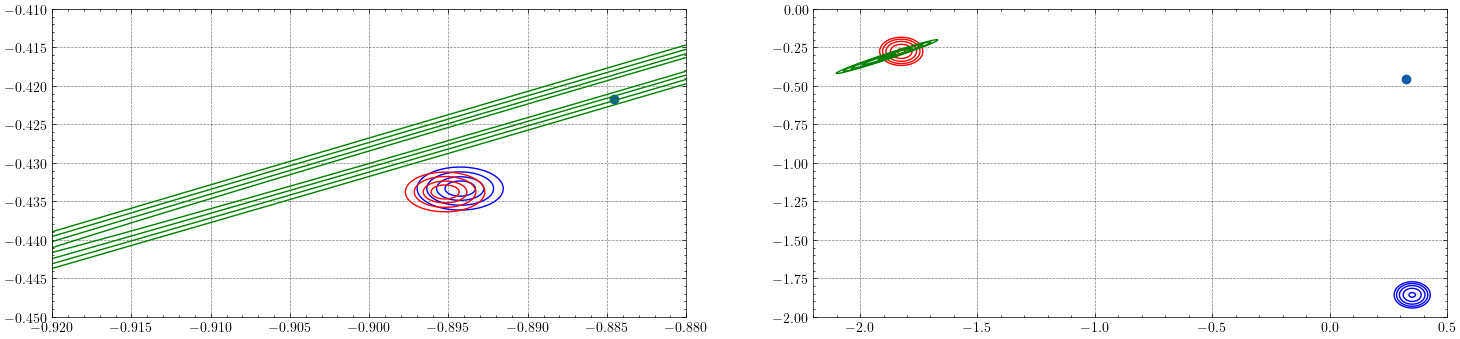

In [381]:
fig, axs = plt.subplots(1,2, figsize = (18,4))

levels1 = [0.1,0.25,0.5,0.75,1]
levels2 = [0.0001,0.001,0.01,0.1,0.75,1]

# Gaussian
axs[0].contour(X1, Y1, pdf_uni_1, levels=levels1, colors = "blue")
#Mixture
axs[0].contour(X1, Y1, pdf_mix_1, levels=levels1, colors = "red")
#Mvnormal
axs[0].contour(X1, Y1, pdf_mvnorm_1, levels=levels1, colors = "green")
#Det
axs[0].scatter(*mean_pred[:,0])


# Gaussian
axs[1].contour(X2, Y2, pdf_uni_2, levels=levels2, colors = "blue")
# Mixture
axs[1].contour(X2, Y2, pdf_mix_2, levels=levels2, colors = "red")
#Mvnormal
axs[1].contour(X2, Y2, pdf_mvnorm_2, levels=levels2, colors = "green")
# Det
axs[1].scatter(*mean_pred[:,-1])


axs[0].set_xlim([-0.92,-0.88])
axs[0].set_ylim([-0.45,-0.41])

axs[1].set_xlim([-2.2,0.5])
axs[1].set_ylim([-2,0])